In [1]:
%load_ext autoreload

In [2]:
import os
os.chdir("../")

In [3]:
%autoreload 2
import math
import numpy as np
from tqdm.auto import trange
from IPython.display import clear_output

import torch
import torch.nn as nn

import matplotlib.pyplot as plt
%matplotlib inline


import sys
sys.path.append('./external/sg3')
sys.path.append('./external/hamiltorch')


from sb.nn.reward import ClsReward
from sb.data.datasets import ClsRewardDist, MixOfGaussians
from sb.utils import plot_annotated_images

/opt/saturncloud/envs/sg3/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/opt/saturncloud/envs/sg3/lib/python3.9/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [4]:
celeba_feats = {
     0: "5_o_Clock_Shadow",
     1: "Arched_Eyebrows",
     2: "Attractive",
     3: "Bags_Under_Eyes",
     4: "Bald",
     5: "Bangs",
     6: "Big_Lips",
     7: "Big_Nose",
     8: "Black_Hair",
     9: "Blond_Hair",
    10: "Blurry",
    11: "Brown_Hair",
    12: "Bushy_Eyebrows",
    13: "Chubby",
    14: "Double_Chin",
    15: "Eyeglasses",
    16: "Goatee",
    17: "Gray_Hair",
    18: "Heavy_Makeup",
    19: "High_Cheekbones",
    20: "Male",
    21: "Mouth_Slightly_Open",
    22: "Mustache",
    23: "Narrow_Eyes",
    24: "No_Beard",
    25: "Oval_Face",
    26: "Pale_Skin",
    27: "Pointy_Nose",
    28: "Receding_Hairline",
    29: "Rosy_Cheeks",
    30: "Sideburns",
    31: "Smiling",
    32: "Straight_Hair",
    33: "Wavy_Hair",
    34: "Wearing_Earrings",
    35: "Wearing_Hat",
    36: "Wearing_Lipstick",
    37: "Wearing_Necklace",
    38: "Wearing_Necktie",
    39: "Young",
}

In [5]:
device = torch.device('cuda:1')

# rwd_dist = ClsRewardDist('cifar10-gan-z256', 'cifar10-cls', 50, [5], 'sum', device)
rwd_dist = ClsRewardDist('cifar10-stylegan', 'cifar10-cls', 512, [5], 'sum', device)
# rwd_dist = ClsRewardDist('celeba-stylegan', 'celeba-cls-32x32', 512, [9], 'sum', device)

/home/jovyan/workspace/energy-sb/./external/sg3/torch_utils/ops/conv2d_gradfix.py:14: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


In [6]:
def compute_grad(fn, x):
    x_ = x.detach().clone().requires_grad_(True)    
    o = fn(x_)
    o.sum().backward()
    return o, x_.grad


def mala_correction(x, logp_x, grad_logp_x, y, logp_y, grad_logp_y, dt):
    adj = logp_y - logp_x + \
          (y - x - dt * grad_logp_x).pow(2).sum(1) / (4 * dt) - \
          (x - y - dt * grad_logp_y).pow(2).sum(1) / (4 * dt)

    adj = torch.minimum(torch.ones_like(adj), adj.exp())
    return torch.rand_like(adj) < adj

In [11]:
method = 'ula' # ula, mala

x = torch.randn(32, 512, device=device)

dt = 0.07
num_steps = 300
anneal_value = 0.1

lmbda = 0.0
grad_lmbda = 0.0
alpha = math.exp(math.log(anneal_value) / num_steps)

prev_z = None
ema_grad = 0
precision, mean_log_reward, adj_fracs = [], [], []

for it in trange(num_steps):
    if method == 'ula':
        _, grad = compute_grad(rwd_dist.log_density, x)
        # ema_grad = grad_lmbda * ema_grad + (1 - grad_lmbda) * grad

        curr_z = torch.randn_like(x)
        z = curr_z if prev_z is None else (curr_z + prev_z) / 2
        prev_z = curr_z

        y = x + grad * dt + math.sqrt(2 * dt) * z

        x = lmbda * x + (1 - lmbda) * y
        adj_fracs.append(1.0)
    
    elif method == 'mala':
        logp_x, grad_logp_x = compute_grad(rwd_dist.log_density, x)

        z = torch.randn_like(x)
        y = x + grad_logp_x * dt + math.sqrt(2 * dt) * z

        logp_y, grad_logp_y = compute_grad(rwd_dist.log_density, y)

        adj = mala_correction(x, logp_x, grad_logp_x, 
                            y, logp_y, grad_logp_y, 
                            dt)
        adj_fracs.append(adj.float().mean().item())
        x[adj] = y[adj]

    dt *= alpha

    with torch.no_grad():
        img = rwd_dist.reward.generator(x)
        img = img * 0.5 + 0.5
        
        n_classes = len(rwd_dist.reward.target_classes)
        probas = rwd_dist.reward.classifier(img).softmax(dim=1)
        target_probas = probas[:, rwd_dist.reward.target_classes]
        
        reward = rwd_dist.reward.reward_fn(target_probas)
        mean_log_rwd = (reward / n_classes).log().mean().cpu()
        
        prc = (target_probas > 0.5).float().mean().cpu()

    precision.append(prc)
    mean_log_reward.append(mean_log_rwd)

  0%|          | 0/300 [00:00<?, ?it/s]

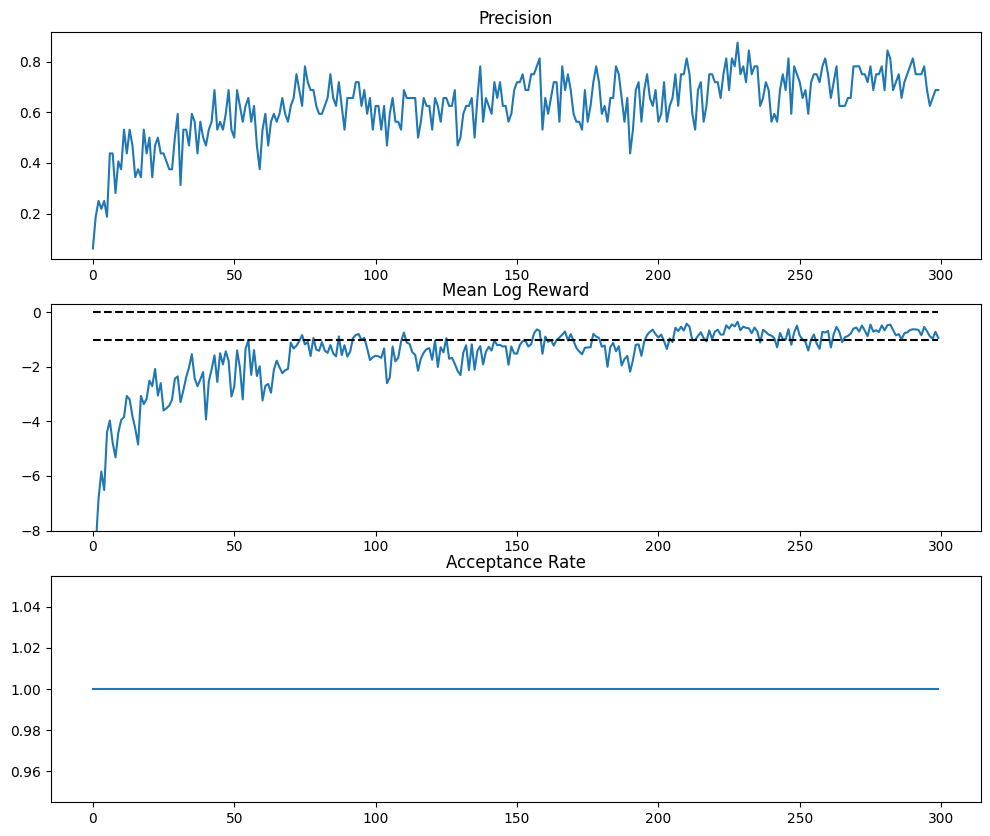

In [13]:
f, ax = plt.subplots(3, 1, figsize=(12, 10))
names = ['Precision', 'Mean Log Reward', 'Acceptance Rate']

for i, graph  in enumerate([
    precision, mean_log_reward, adj_fracs
]):
    ax[i].set_title(names[i])
    ax[i].plot(graph)
    if i == 1:
        ax[i].plot([-1]*len(graph), 'k--', label='0')
        ax[i].plot([0]*len(graph), 'k--', label='0')
        ax[i].set_ylim(-8, 0.3)
plt.show()

Precision: 0.75, Mean log reward: -0.942


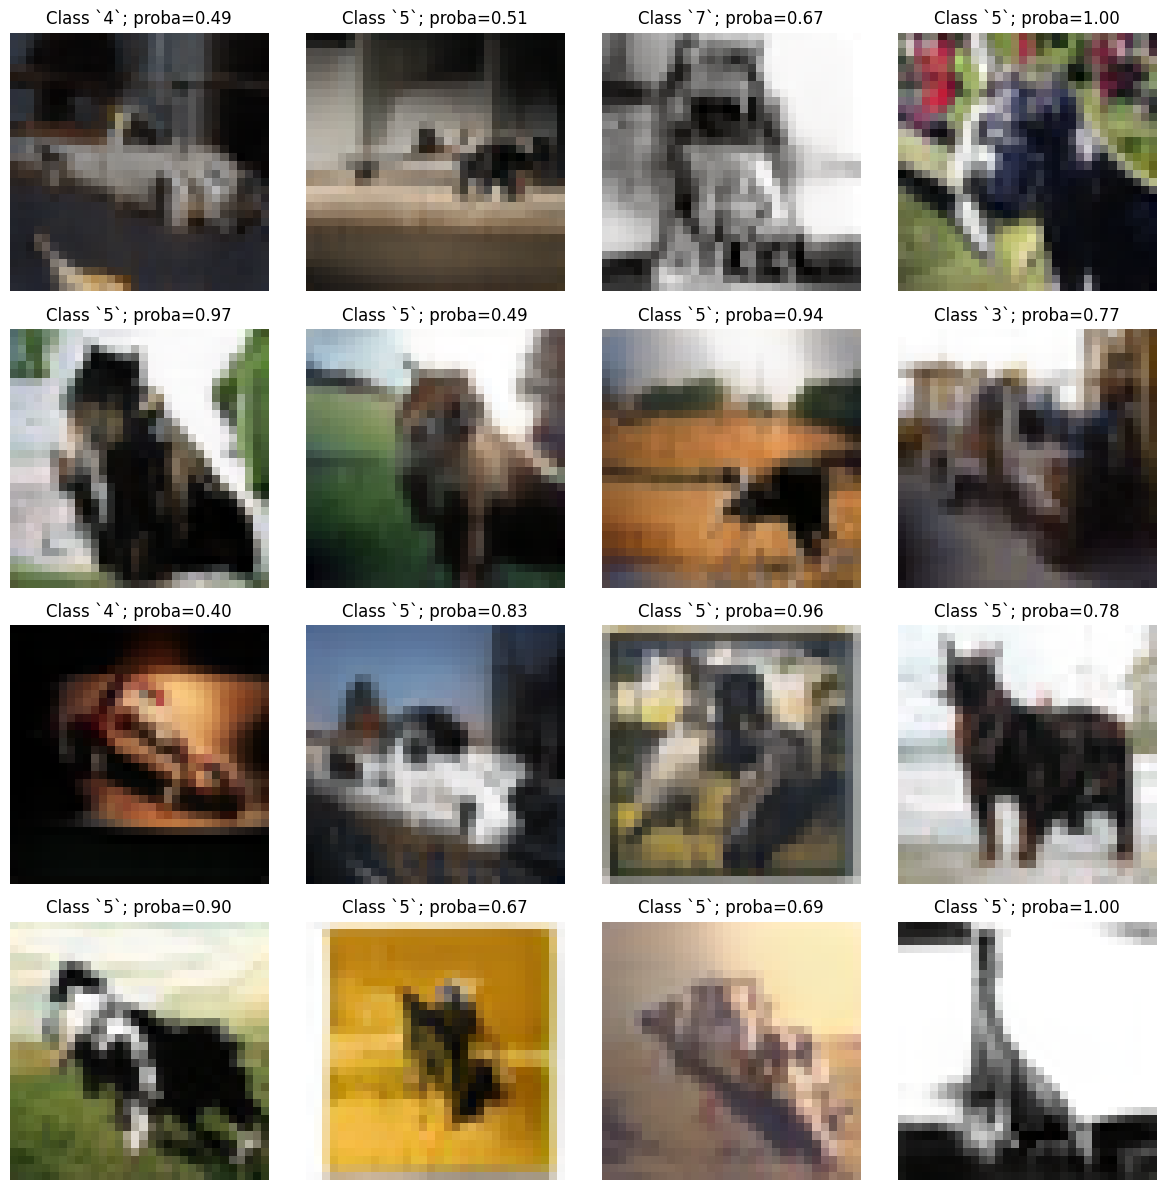

In [17]:
with torch.no_grad():
    img = rwd_dist.reward.generator(x)
    img = torch.clip(img * 0.5 + 0.5, 0, 1)
    
    probas = rwd_dist.reward.classifier(img).softmax(dim=1)
    rwd = rwd_dist.reward.reward_fn(probas[:, rwd_dist.reward.target_classes])
    mean_log_rwd = rwd.log().mean().cpu()
    
    p, c = probas.max(dim=1)
    prc = (c == 5).float().mean().cpu()



print(f"Precision: {prc:.2f}, Mean log reward: {mean_log_rwd:.3f}")
_ = plot_annotated_images(img[:16], (p[:16], c[:16]), n_col=4, figsize=(12, 12))

In [ ]:
    probas = rwd_dist.reward.classifier(img).softmax(dim=1)
    target_probas = probas[:, rwd_dist.reward.target_classes]
    
    reward = rwd_dist.reward.reward_fn(target_probas)
    mean_log_rwd = (reward / n_classes).log().mean().cpu()
    
    prc = (target_probas > 0.5).float().mean().cpu()

In [ ]:
import hamiltorch
hamiltorch.set_random_seed(123)

In [ ]:
x0 = torch.randn(512, device=device)

sampler=hamiltorch.Sampler.HMC
integrator=hamiltorch.Integrator.IMPLICIT


def _log_gensity(x):
    x = x.reshape(1, -1)
    density = rwd_dist.log_density(x)
    return density[0]

xt = params_hmc = hamiltorch.sample(
    log_prob_func=_log_gensity, 
    params_init=x0,  
    num_samples=64, 
    step_size=0.08, 
    num_steps_per_sample=10,
    sampler=sampler, 
    integrator=integrator,
)


In [ ]:
with torch.no_grad():
    x = torch.stack(xt[::4])
    img = rwd_dist.reward.generator(x)
    img = torch.clip(img * 0.5 + 0.5, 0, 1)
    probas = rwd_dist.reward.classifier(img).softmax(dim=1)

(p, c) = probas.max(dim=1)
mean_log_rwd = probas[:, 5].log().mean()

print(
    f"{img.shape[0]=} |",
    f" Precision: {(c == 5).float().mean():.2f} |",
    f"Mean log reward: {mean_log_rwd:.3f}"
)
_ = plot_annotated_images(img[:32], (p[:32], c[:32]), n_col=4, figsize=(12, 24))